**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Tips and Tricks for the Project

### Extract HOG features just once for the entire region of interest in each full image / video frame
In one of the previous exercises you extracted HOG features from each individual window as you searched across the image, but it turns out this is rather inefficient. To speed things up, extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) and subsample that array for each sliding window. To do this, apply skimage.feature.hog() with the flag feature_vec=False, like this:

from skimage.feature import hog
orient = 9
pix_per_cell = 8
cell_per_block = 2

feature_array = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
The output feature_array will have a shape of (n_yblocks, n_xblocks, 2, 2, 9), where n_yblocks and n_xblocks are determined by the shape of your region of interest (i.e. how many blocks fit across and down your image in x and y).

So, for example, if you used cells_per_block=2 in extracting features from the 64x64 pixel training images, then you would want to extract subarrays of shape (7, 7, 2, 2, 9) from feature_array and then use np.ravel() to unroll the feature vector.

### Make sure your images are scaled correctly
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if you are testing your pipeline on .jpg images remember to scale them accordingly. And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() you'll get back an image scaled from 0 to 255. So just be sure to be consistent between your training data features and inference features!

Be sure to normalize your training data
Use sklearn.preprocessing.StandardScaler() to normalize your feature vectors for training your classifier as described in this lesson. Then apply the same scaling to each of the feature vectors you extract from windows in your test images.

### Random shuffling of data
When dealing with image data that was extracted from video, you may be dealing with sequences of images where your target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set.

For the project vehicles dataset, the GTI* folders contain time-series data. In the KITTI folder, you may see the same vehicle appear more than once, but typically under significantly different lighting/angle from other instances.

While it is possible to achieve a sufficiently good result on the project without worrying about time-series issues, if you really want to optimize your classifier, you should devise a train/test split that avoids having nearly identical images in both your training and test sets. This means extracting the time-series tracks from the GTI data and separating the images manually to make sure train and test images are sufficiently different from one another.

## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.misc import toimage
from scipy.ndimage.measurements import label

%matplotlib inline

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


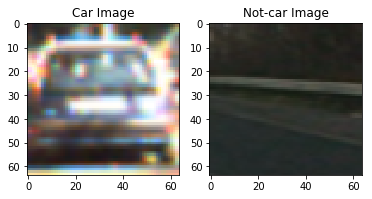

In [39]:
# Car Not Car Lesson

# images are divided up into vehicles and non-vehicles
cars    = glob.glob('./classification_images/vehicles/**/*.png')
notcars = glob.glob('./classification_images/non-vehicles/**/*.png')

# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    sample = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = sample.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = sample.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images
car_ind = 5145 # np.random.randint(0, len(cars))
notcar_ind = 8010 # np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.imread(notcars[notcar_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not-car Image')


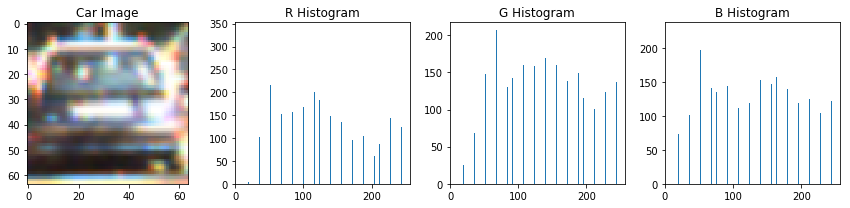

In [40]:
# Histograms of colour Lesson

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts and the original image
fig = plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(142)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(143)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(144)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

In [102]:
# Spatial Bin Lesson
# Define a function to compute color histogram features
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32), convert_color=False, flatten_features=True):
    # Convert image to new color space (if specified)
    if color_space != 'RGB' and convert_color:
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size)
    if flatten_features:
        features = features.ravel()
    # Return the feature vector
    return features

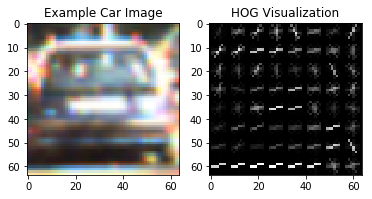

In [484]:
# Get Hog Lesson

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False):
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    if vis == True:
        return features, hog_image
    else:
        return features

gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient,
                        pix_per_cell, cell_per_block,
                        vis=True)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [446]:
# Norm Shuffle Lesson

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), flatten_features=True):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    if flatten_features:
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    else:
        return [channel1_hist, channel2_hist, channel3_hist]

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_spatial_and_colour_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for path in imgs:
        # Read in each one by one
        image = cv2.imread(path)
        # apply color conversion if other than 'RGB'
        if cspace == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif cspace == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(image, spatial_size)
        # Apply color_hist() to get color histogram features
        colour_features = color_hist(image, hist_bins, hist_range)
        # Append the new feature vector to the features list
        feature_vec = np.concatenate((spatial_features, colour_features), axis=0)
        features.append(feature_vec)
    # Return list of feature vectors
    return features

car_spatial_and_colour_features    = extract_spatial_and_colour_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_spatial_and_colour_features = extract_spatial_and_colour_features(notcars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

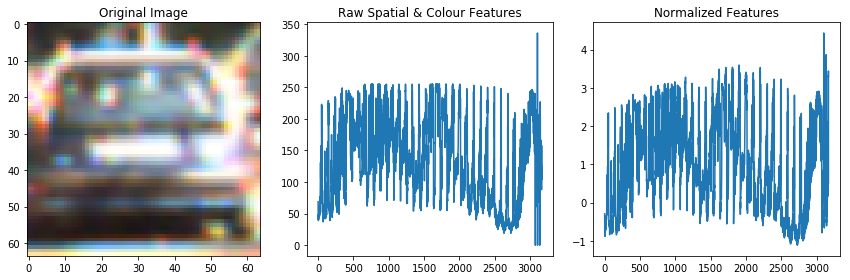

In [87]:
# Create an array stack of feature vectors
X = np.vstack((car_spatial_and_colour_features, notcar_spatial_and_colour_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Spatial & Colour Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [88]:
# Colour Classifier Lesson

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 64
histbin = 64

car_spatial_and_colour_features = extract_spatial_and_colour_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_spatial_and_colour_features = extract_spatial_and_colour_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_spatial_and_colour_features, notcar_spatial_and_colour_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_spatial_and_colour_features)), np.zeros(len(notcar_spatial_and_colour_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Using spatial binning of: 64 and 64 histogram bins
Feature vector length: 3264
19.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9611
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00186 Seconds to predict 10 labels with SVC


In [89]:
# Using spatial binning of: 16 and 16 histogram bins
# Feature vector length: 3120
# 24.32 Seconds to train SVC...
# Test Accuracy of SVC =  0.9443
# My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
# For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
# 0.00196 Seconds to predict 10 labels with SVC

# Using spatial binning of: 24 and 24 histogram bins
# Feature vector length: 3144
# 21.82 Seconds to train SVC...
# Test Accuracy of SVC =  0.9535
# My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
# For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
# 0.002 Seconds to predict 10 labels with SVC

# Using spatial binning of: 32 and 32 histogram bins
# Feature vector length: 3168
# 19.87 Seconds to train SVC...
# Test Accuracy of SVC =  0.9589
# My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
# For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  1.  1.]
# 0.00192 Seconds to predict 10 labels with SVC

# Using spatial binning of: 64 and 64 histogram bins
# Feature vector length: 3264
# 19.44 Seconds to train SVC...
# Test Accuracy of SVC =  0.9628
# My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
# For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
# 0.00264 Seconds to predict 10 labels with SVC

# Using spatial binning of: 128 and 128 histogram bins
# Feature vector length: 3456
# 19.47 Seconds to train SVC...
# Test Accuracy of SVC =  0.9642
# My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
# For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
# 0.00211 Seconds to predict 10 labels with SVC

In [491]:
# Hog Classifier Lesson


def image_features(img, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), flatten_features=True):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    
        
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size, flatten_features=flatten_features)
    # Apply color_hist() to get color histogram features
    hist_features = color_hist(feature_image, hist_bins, hist_range, flatten_features=flatten_features)

    
    features_dict = {}
    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog, hog_img = get_hog_features(feature_image[:,:,channel],
                                orient, pix_per_cell, cell_per_block,
                                vis=True)
            hog_features.append(hog)
            dict_key = 'ch{}_hog_img'.format(channel + 1)
            features_dict[dict_key] = hog_img
            
    else:
        hog_features, hog_img = get_hog_features(feature_image[:,:,hog_channel], orient,
                    pix_per_cell, cell_per_block, vis=True)
        dict_key = 'ch{}_hog_img'.format(hog_channel + 1)
        features_dict[dict_key] = hog_img
    
    if flatten_features:
        hog_features = np.ravel(hog_features)

        feature_vec = np.concatenate((hog_features, spatial_features, hist_features), axis=0)
        return feature_vec
    
    for channel in range(feature_image.shape[2]):
        spat_dict_key = 'ch{}_spat_feat'.format(channel + 1)
        features_dict[spat_dict_key] = spatial_features[:,:,channel]
        
        hist_dict_key = 'ch{}_hist_feat'.format(channel + 1)
        features_dict[hist_dict_key] = hist_features[channel]
    
    return features_dict 

In [489]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Append the new feature vector to the features list
        feature_vec = image_features(image, cspace=cspace, orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     hist_range=hist_range, flatten_features=True)
        features.append(feature_vec)
    # Return list of feature vectors
    return features

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 16
spatial_size = (spatial, spatial)
hist_bins = 32


t=time.time()
car_features = extract_features(cars, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_size=spatial_size, 
                                hist_bins=hist_bins, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_size=spatial_size, 
                                hist_bins=hist_bins, hist_range=(0, 256))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

742.28 Seconds to extract HOG features...


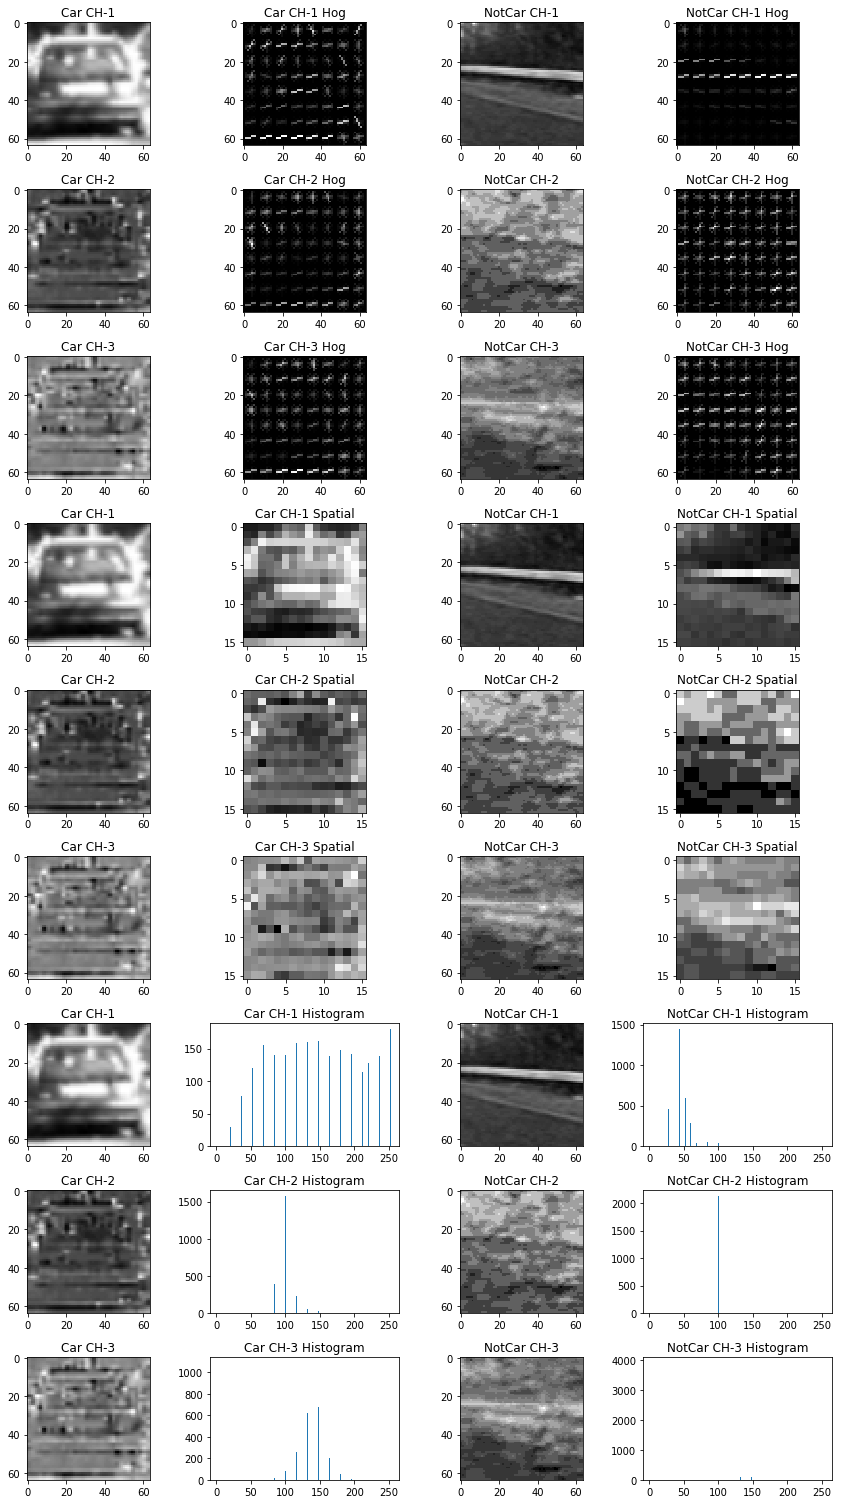

In [492]:
car_example_features = image_features(car_image, cspace=color_space, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_size=spatial_size, 
                                        hist_bins=hist_bins, hist_range=(0, 256), flatten_features=False)
notcar_example_features = image_features(notcar_image, cspace=color_space, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_size=spatial_size, 
                                        hist_bins=hist_bins, hist_range=(0, 256), flatten_features=False)

car_image_converted = cv2.cvtColor(car_image, cv2.COLOR_RGB2LUV)
notcar_image_converted = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2LUV)

fig, axarr = plt.subplots(9, 4, figsize=(12,21))

# Row 1

axarr[0, 0].imshow(car_image_converted[:,:,0], cmap='gray')
axarr[0, 0].set_title('Car CH-{}'.format(1))

axarr[0, 1].imshow(car_example_features['ch{}_hog_img'.format(1)], cmap='gray')
axarr[0, 1].set_title('Car CH-{} Hog'.format(1))

axarr[0, 2].imshow(notcar_image_converted[:,:,0], cmap='gray')
axarr[0, 2].set_title('NotCar CH-{}'.format(1))

axarr[0, 3].imshow(notcar_example_features['ch{}_hog_img'.format(1)], cmap='gray')
axarr[0, 3].set_title('NotCar CH-{} Hog'.format(1))

# Row 2

axarr[1, 0].imshow(car_image_converted[:,:,1], cmap='gray')
axarr[1, 0].set_title('Car CH-{}'.format(2))

axarr[1, 1].imshow(car_example_features['ch{}_hog_img'.format(2)], cmap='gray')
axarr[1, 1].set_title('Car CH-{} Hog'.format(2))

axarr[1, 2].imshow(notcar_image_converted[:,:,1], cmap='gray')
axarr[1, 2].set_title('NotCar CH-{}'.format(2))

axarr[1, 3].imshow(notcar_example_features['ch{}_hog_img'.format(2)], cmap='gray')
axarr[1, 3].set_title('NotCar CH-{} Hog'.format(2))

# Row 3

axarr[2, 0].imshow(car_image_converted[:,:,2], cmap='gray')
axarr[2, 0].set_title('Car CH-{}'.format(3))

axarr[2, 1].imshow(car_example_features['ch{}_hog_img'.format(3)], cmap='gray')
axarr[2, 1].set_title('Car CH-{} Hog'.format(3))

axarr[2, 2].imshow(notcar_image_converted[:,:,2], cmap='gray')
axarr[2, 2].set_title('NotCar CH-{}'.format(3))

axarr[2, 3].imshow(notcar_example_features['ch{}_hog_img'.format(3)], cmap='gray')
axarr[2, 3].set_title('NotCar CH-{} Hog'.format(3))

# Row 4

axarr[3, 0].imshow(car_image_converted[:,:,0], cmap='gray')
axarr[3, 0].set_title('Car CH-1')

axarr[3, 1].imshow(car_example_features['ch1_spat_feat'], cmap='gray')
axarr[3, 1].set_title('Car CH-1 Spatial')

axarr[3, 2].imshow(notcar_image_converted[:,:,0], cmap='gray')
axarr[3, 2].set_title('NotCar CH-1')

axarr[3, 3].imshow(notcar_example_features['ch1_spat_feat'], cmap='gray')
axarr[3, 3].set_title('NotCar CH-1 Spatial')

# Row 5

axarr[4, 0].imshow(car_image_converted[:,:,1], cmap='gray')
axarr[4, 0].set_title('Car CH-2')

axarr[4, 1].imshow(car_example_features['ch2_spat_feat'], cmap='gray')
axarr[4, 1].set_title('Car CH-2 Spatial')

axarr[4, 2].imshow(notcar_image_converted[:,:,1], cmap='gray')
axarr[4, 2].set_title('NotCar CH-2')

axarr[4, 3].imshow(notcar_example_features['ch2_spat_feat'], cmap='gray')
axarr[4, 3].set_title('NotCar CH-2 Spatial')


# Row 6

axarr[5, 0].imshow(car_image_converted[:,:,2], cmap='gray')
axarr[5, 0].set_title('Car CH-3')

axarr[5, 1].imshow(car_example_features['ch3_spat_feat'], cmap='gray')
axarr[5, 1].set_title('Car CH-3 Spatial')

axarr[5, 2].imshow(notcar_image_converted[:,:,2], cmap='gray')
axarr[5, 2].set_title('NotCar CH-3')

axarr[5, 3].imshow(notcar_example_features['ch3_spat_feat'], cmap='gray')
axarr[5, 3].set_title('NotCar CH-3 Spatial')

# Row 7

axarr[6, 0].imshow(car_image_converted[:,:,0], cmap='gray')
axarr[6, 0].set_title('Car CH-1')

bin_edges = car_example_features['ch1_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[6, 1].bar(bin_centers, car_example_features['ch1_hist_feat'][0])
axarr[6, 1].set_title('Car CH-1 Histogram')

axarr[6, 2].imshow(notcar_image_converted[:,:,0], cmap='gray')
axarr[6, 2].set_title('NotCar CH-1')

bin_edges = notcar_example_features['ch1_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[6, 3].bar(bin_centers, notcar_example_features['ch1_hist_feat'][0])
axarr[6, 3].set_title('NotCar CH-1 Histogram')

# Row 8

axarr[7, 0].imshow(car_image_converted[:,:,1], cmap='gray')
axarr[7, 0].set_title('Car CH-2')

bin_edges = car_example_features['ch2_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[7, 1].bar(bin_centers, car_example_features['ch2_hist_feat'][0])
axarr[7, 1].set_title('Car CH-2 Histogram')

axarr[7, 2].imshow(notcar_image_converted[:,:,1], cmap='gray')
axarr[7, 2].set_title('NotCar CH-2')

bin_edges = notcar_example_features['ch2_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[7, 3].bar(bin_centers, notcar_example_features['ch2_hist_feat'][0])
axarr[7, 3].set_title('NotCar CH-2 Histogram')

# Row 9

axarr[8, 0].imshow(car_image_converted[:,:,2], cmap='gray')
axarr[8, 0].set_title('Car CH-3')

bin_edges = car_example_features['ch3_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[8, 1].bar(bin_centers, car_example_features['ch3_hist_feat'][0])
axarr[8, 1].set_title('Car CH-3 Histogram')

axarr[8, 2].imshow(notcar_image_converted[:,:,2], cmap='gray')
axarr[8, 2].set_title('NotCar CH-3')

bin_edges = notcar_example_features['ch3_hist_feat'][1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
axarr[8, 3].bar(bin_centers, notcar_example_features['ch3_hist_feat'][0])
axarr[8, 3].set_title('NotCar CH-3 Histogram')

fig.tight_layout()

In [493]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
18.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9851
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00163 Seconds to predict 10 labels with SVC


In [ ]:
# colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 2 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# histbin = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4932
# 15.08 Seconds to train SVC...
# Test Accuracy of SVC =  0.9828
# My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]
# For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]
# 0.00198 Seconds to predict 10 labels with SVC



# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 1 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# histbin = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4932
# 15.85 Seconds to train SVC...
# Test Accuracy of SVC =  0.9797
# My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
# For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
# 0.00186 Seconds to predict 10 labels with SVC



# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 1 # Can be 0, 1, 2, or "ALL"
# spatial = 16
# spatial_size = (spatial, spatial)
# hist_bins = 16

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 2580
# 6.5 Seconds to train SVC...
# Test Accuracy of SVC =  0.9783
# My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
# For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
# 0.00167 Seconds to predict 10 labels with SVC



# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4884
# 21.39 Seconds to train SVC...
# Test Accuracy of SVC =  0.9569
# My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
# For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
# 0.00254 Seconds to predict 10 labels with SVC



# color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 2 # Can be 0, 1, 2, or "ALL"
# spatial = 16
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 2580
# 6.45 Seconds to train SVC...
# Test Accuracy of SVC =  0.9778
# My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
# For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
# 0.00193 Seconds to predict 10 labels with SVC



# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 2 # Can be 0, 1, 2, or "ALL"
# spatial = 16
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 2580
# 9.73 Seconds to train SVC...
# Test Accuracy of SVC =  0.96
# My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
# For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
# 0.00222 Seconds to predict 10 labels with SVC



# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 1 # Can be 0, 1, 2, or "ALL"
# spatial = 16
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 2580
# 8.22 Seconds to train SVC...
# Test Accuracy of SVC =  0.9603
# My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
# For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
# 0.00192 Seconds to predict 10 labels with SVC



# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4884
# 15.54 Seconds to train SVC...
# Test Accuracy of SVC =  0.9789
# My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
# For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
# 0.00201 Seconds to predict 10 labels with SVC



# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4884
# 16.35 Seconds to train SVC...
# Test Accuracy of SVC =  0.9735
# My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
# For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
# 0.00191 Seconds to predict 10 labels with SVC



# color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 4884
# 15.26 Seconds to train SVC...
# Test Accuracy of SVC =  0.9769
# My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
# For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
# 0.00221 Seconds to predict 10 labels with SVC



# color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 8412
# 7.84 Seconds to train SVC...
# Test Accuracy of SVC =  0.9893
# My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
# For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
# 0.00194 Seconds to predict 10 labels with SVC



# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 8412
# 26.16 Seconds to train SVC...
# Test Accuracy of SVC =  0.9868
# My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
# For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
# 0.00282 Seconds to predict 10 labels with SVC


# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 15
# pix_per_cell = 8
# cell_per_block = 4
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial = 32
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 15 orientations 8 pixels per cell and 4 cells per block
# Feature vector length: 21120
# 50.27 Seconds to train SVC...
# Test Accuracy of SVC =  0.9834
# My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
# For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
# 0.04009 Seconds to predict 10 labels with SVC



# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial = 16
# spatial_size = (spatial, spatial)
# hist_bins = 32

# Using: 9 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 6156
# 18.81 Seconds to train SVC...
# Test Accuracy of SVC =  0.9851
# My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
# For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
# 0.00163 Seconds to predict 10 labels with SVC

## Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

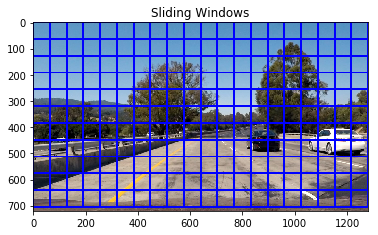

In [850]:
# sliding windows
test_image = mpimg.imread('./test_images/test1.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)
plt.title('Sliding Windows')


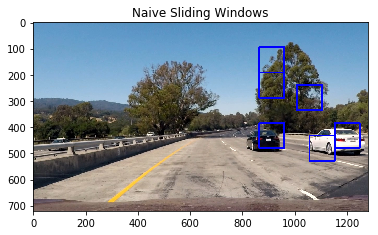

In [857]:
# search classify

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = image_features(test_img, cspace=cspace,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


draw_image = np.copy(test_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
test_image = test_image.astype(np.float32)/255

windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(test_image, windows, svc, X_scaler, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)
plt.title('Naive Sliding Windows')


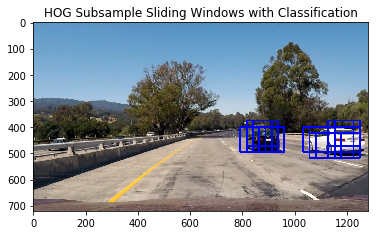

In [852]:
# hog subsample

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              hog_channel, spatial_size, hist_bins, cells_per_step=2, preprocess_image=True, verbose=False):
    
    box_list = []
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    
    if preprocess_image:
        img_tosearch = img_tosearch.astype(np.float32)/255
        img_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    # Instead of overlap, we use cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block)

    if verbose:
        print('nxsteps: {}, nysteps: {}'.format(nxsteps, nysteps))
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            
            hog_features = [hog_feat1, hog_feat2, hog_feat3]
            
            if hog_channel != 'ALL':
                hog_features = hog_channel[hog_channel]
            
            hog_features = np.ravel(hog_features)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            feature_vec = np.concatenate((hog_features, spatial_features, hist_features), axis=0)
            
            test_features = X_scaler.transform([feature_vec]).reshape(1, -1)
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)])

    return box_list

ystart = 375
ystop = 600
xstart = 0
xstop = 1280
scale = 1.5

box_list = find_cars(test_image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, 
                     pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

out_img =  np.copy(test_image)

for box in box_list:
    cv2.rectangle(out_img, box[0], box[1], (0,0,255), 6)

plt.imshow(out_img)
plt.title('HOG Subsample Sliding Windows with Classification')


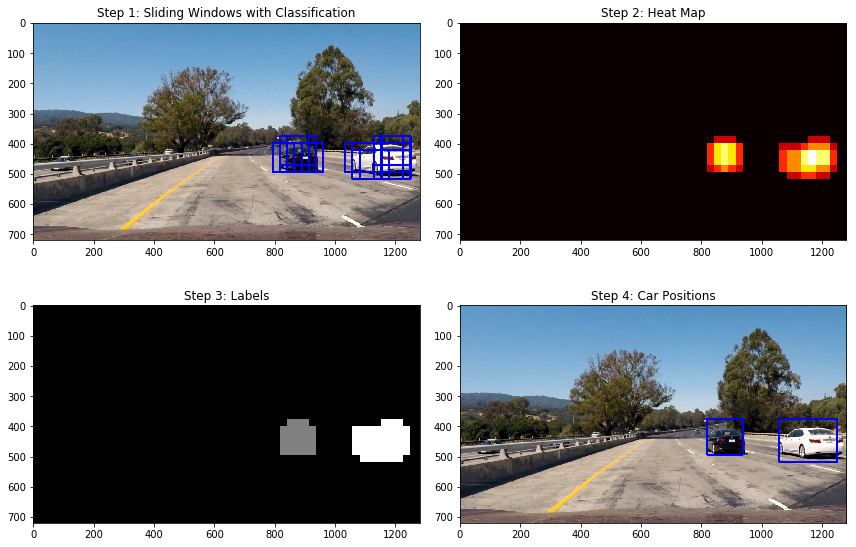

In [828]:
# multiple detections and false positives Lesson

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def find_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
    return bboxes

def draw_labeled_bboxes(img, bboxes):
    # Iterate through all detected cars
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
bboxes = find_labeled_bboxes(labels)
draw_img = draw_labeled_bboxes(np.copy(test_image), bboxes)



fig = plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(out_img)
plt.title('Step 1: Sliding Windows with Classification')
plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Step 2: Heat Map')
plt.subplot(223)
plt.imshow(labels[0], cmap='gray')
plt.title('Step 3: Labels')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Step 4: Car Positions')
fig.tight_layout()


## Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

(start with the test_video.mp4 and later implement on full project_video.mp4)

In [845]:
# Check if the bounding box is big enough, the right shape, and in the right place
def good_bbox(bbox):
    width  = bbox[1][0]-bbox[0][0]
    height = bbox[1][1]-bbox[0][1]
    min_dimension = min(width, height)
    big_enough  = min_dimension > 24
    right_shape = width > height*0.7 or min_dimension > 128
    # ystart is too low in the perspective to represent a car.     
    too_low_on_the_road = bbox[0][1] > 425 and min_dimension < 128
    return big_enough and right_shape and not too_low_on_the_road
   

def detect_vehicles_in_image(image, classifier, heatmap_threshold=1, previous_heatmap=[], 
                             return_image_and_heatmap=False, return_image_heatmap_and_labels=False,
                             verbose=False, search_type='full'):
    if search_type == 'skip' and len(previous_heatmap) > 0:
        heatmap = previous_heatmap
    else:
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        spatial = 16
        spatial_size = (spatial, spatial)
        hist_bins = 32
        cells_per_step = 1

        all_boxes = []   
        search_settings = []
        hotspot_y_padding = 32
        hotspot_x_padding = 128
        y_range = image.shape[0]
        x_range = image.shape[1]
        
        if search_type == 'limited' and len(previous_heatmap) > 0:
            labels = label(previous_heatmap)
            for bbox in find_labeled_bboxes(labels):
                if verbose:
                    print('hotspot at {}'.format(bbox))
                top_left = bbox[0]
                bottom_right = bbox[1]
                ystart = max(375, top_left[1] - hotspot_y_padding)
                ystop  = min(y_range - 100, bottom_right[1] + hotspot_y_padding*2)
                xstart = max(0, top_left[0] - hotspot_x_padding)
                xstop  = min(x_range, bottom_right[0] + hotspot_x_padding)
                
                # If the bounding box is small, include a searches with scales 0.75 and 1.0
                if min(ystop - ystart, xstop - xstart) < 128:
                    search_settings.append((ystart, ystop, xstart, xstop, 0.75))
                    search_settings.append((ystart, ystop, xstart, xstop, 1.0))
                
                search_settings.append((ystart, ystop, xstart, xstop, 1.5))
                search_settings.append((ystart, ystop, xstart, xstop, 2.0))
                
                # If the bounding box is big, include a search with scale 2.5
                if min(ystop - ystart, xstop - xstart) > 256:
                    search_settings.append((ystart, ystop, xstart, xstop, 2.5))
        elif search_type == 'light':
            # Search the entire x range of the image but only search at 
            # a single 'medium' scale
            search_settings = [(375, 625, 0, x_range, 1.5)]
            # Override the heatmap threshold as there will be fewer windows.            
            heatmap_threshold = 1
        else:
            # implicitly search_type == 'full'
            # Search the entire x range of the image.
            search_settings = [
                (400, 550, 0, x_range, 0.75),
                (375, 550, 0, x_range, 1.0),
                (375, 575, 0, x_range, 1.5),
                (375, 600, 0, x_range, 2.0),
                (375, 625, 0, x_range, 2.5)
            ]

        # Convert the imeage before the loop to avoid multiple conversions.     
        preprocessed_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        # Normalise pixel values as the classifier was trained on PNG images read in as values from 0 to 1.     
        preprocessed_image = preprocessed_image.astype(np.float32)/255


        for ystart, ystop, xstart, xstop, scale in search_settings:  
            if verbose:
                print('Search Settings: ystart: {}, ystop: {}, xstart: {}, xstop: {}, scale: {}'.format(ystart, ystop, xstart, xstop, scale))
            box_list = find_cars(preprocessed_image, ystart, ystop, xstart, xstop, 
                                 scale, classifier, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, hog_channel, spatial_size, hist_bins,
                                 cells_per_step=cells_per_step, verbose=verbose, preprocess_image=False)
            all_boxes.append(box_list)

        # Turn the nested list of bozes into a single list 
        boxes = [box for some_boxes in all_boxes for box in some_boxes]

        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, boxes)

        if len(previous_heatmap) > 0:
            # Set all non-zero values in the previous heatmap to the threshold. 
            # This will ensure that a bright hotspot from one frame doesn't linger.       
            previous_heatmap[previous_heatmap > 0] = heatmap_threshold
            heat = cv2.addWeighted(heat, 1, previous_heatmap, 0.75, 0)

        heat = apply_threshold(heat, heatmap_threshold)
        heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    bboxes = find_labeled_bboxes(labels)
    # Exclude bboxes that are probably false postives from their size and shape.
    bboxes = [bbox for bbox in bboxes if good_bbox(bbox)]
    draw_img = draw_labeled_bboxes(np.copy(image), bboxes)
    
    if return_image_heatmap_and_labels:
        return draw_img, heatmap, labels
    
    if return_image_and_heatmap:
        return draw_img, heatmap
    
    return draw_img

16.45 seconds to analyse image
16.97 seconds to analyse image
16.04 seconds to analyse image
16.84 seconds to analyse image
16.58 seconds to analyse image
16.72 seconds to analyse image


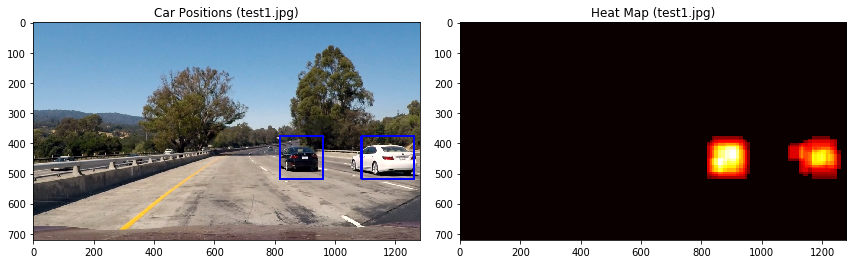

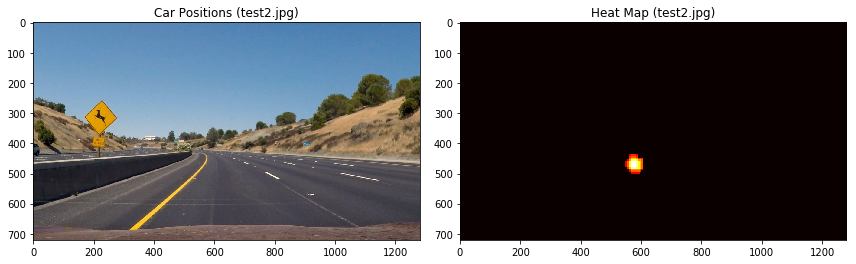

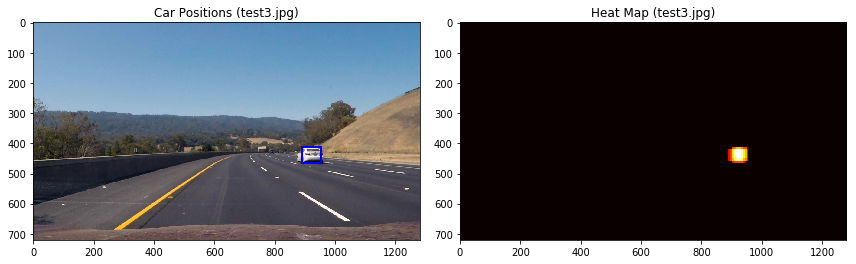

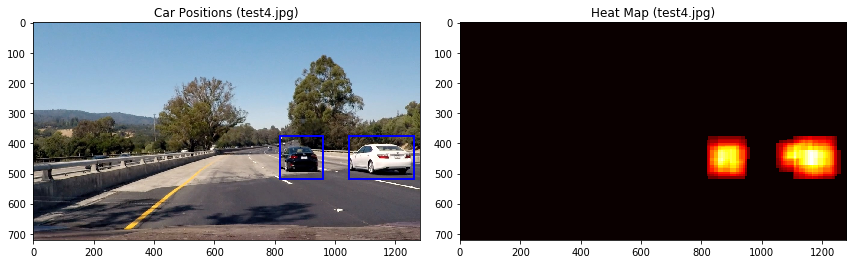

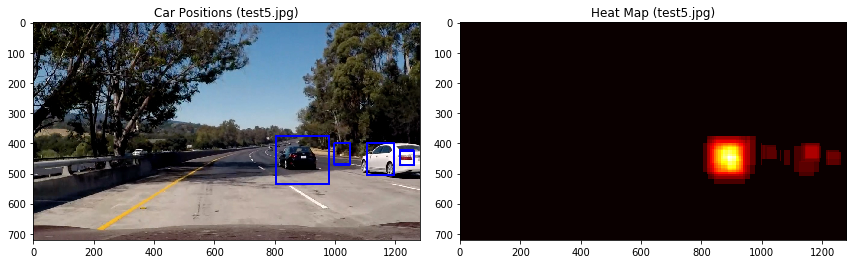

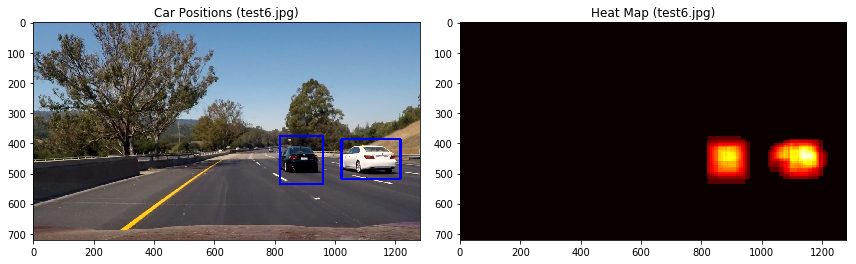

In [843]:
test_images = glob.glob('./test_images/*.jpg')
test_images
for fname in test_images:
    image = cv2.imread(fname)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    t=time.time()
    annotated_image, heatmap = detect_vehicles_in_image(rgb_image, svc, 
                                                        heatmap_threshold=3,
                                                        search_type='full',
                                                        verbose=False,
                                                        return_image_and_heatmap=True)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to analyse image')
    
    image_name = fname.split('/')[-1]
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(annotated_image)
    plt.title('Car Positions ({})'.format(image_name))
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map ({})'.format(image_name))
    fig.tight_layout()


2.87 seconds to analyse image
0.02 seconds to analyse image
1.6 seconds to analyse image
0.02 seconds to analyse image
1.44 seconds to analyse image
0.02 seconds to analyse image
1.62 seconds to analyse image
0.02 seconds to analyse image
1.68 seconds to analyse image
0.02 seconds to analyse image
1.63 seconds to analyse image
0.02 seconds to analyse image
1.59 seconds to analyse image
0.02 seconds to analyse image
1.61 seconds to analyse image
0.02 seconds to analyse image
1.81 seconds to analyse image
0.03 seconds to analyse image
1.74 seconds to analyse image
0.02 seconds to analyse image
1.6 seconds to analyse image


/Users/ejm/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.02 seconds to analyse image
1.36 seconds to analyse image
0.02 seconds to analyse image
2.64 seconds to analyse image
0.02 seconds to analyse image
1.39 seconds to analyse image
0.02 seconds to analyse image
1.43 seconds to analyse image
0.02 seconds to analyse image
1.44 seconds to analyse image
0.02 seconds to analyse image
1.49 seconds to analyse image
0.02 seconds to analyse image
1.5 seconds to analyse image
0.02 seconds to analyse image
1.5 seconds to analyse image
0.02 seconds to analyse image
Mean frame processing time: 0.8507894736842107


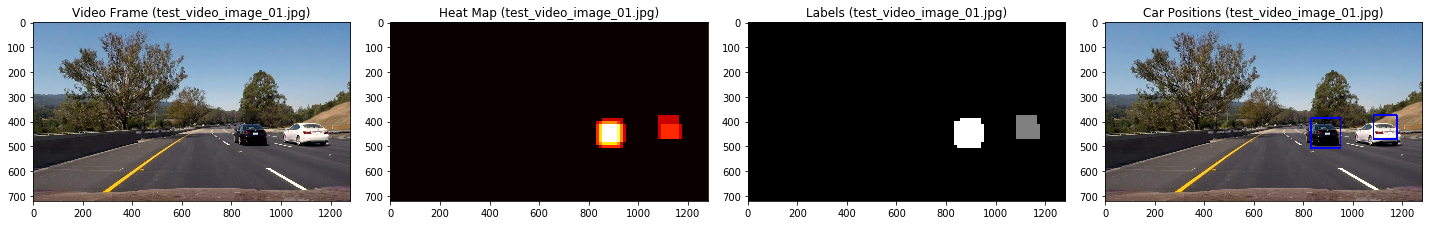

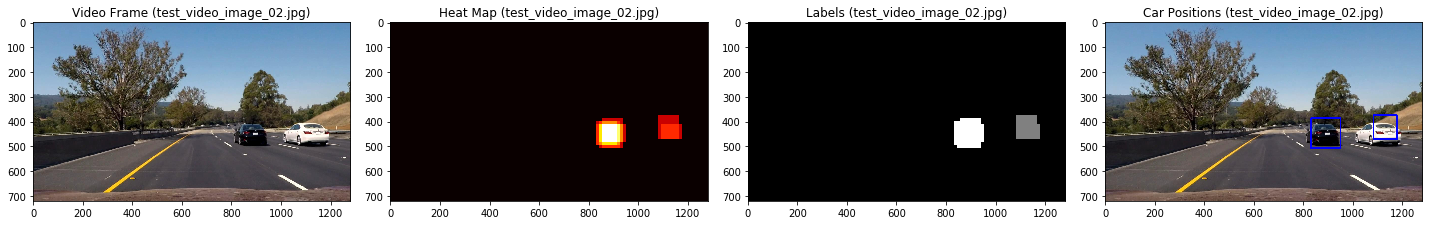

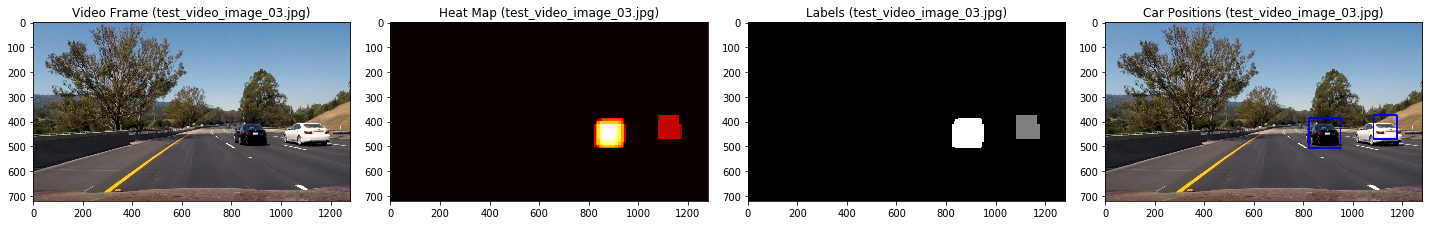

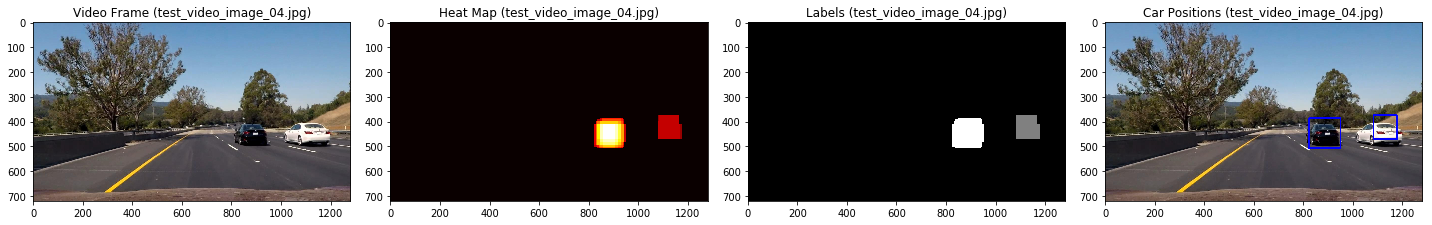

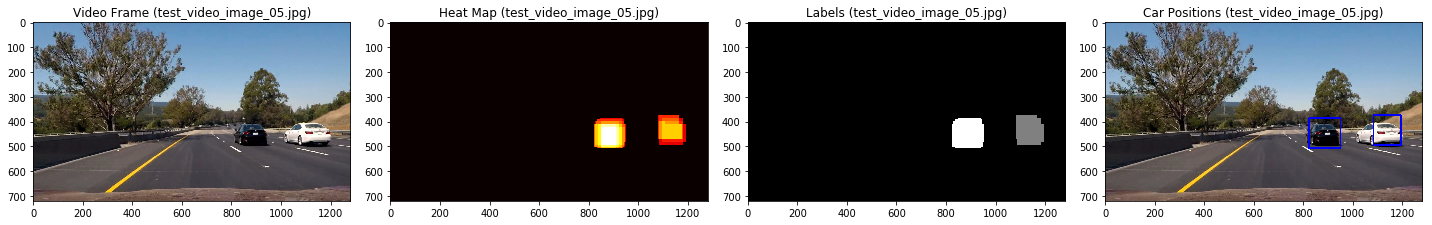

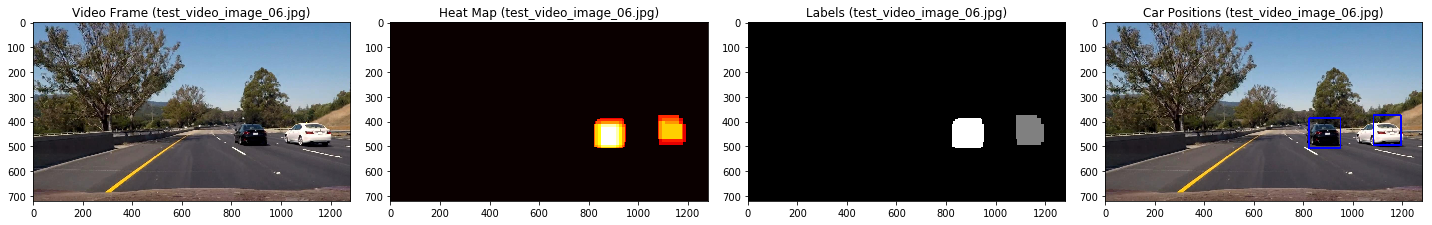

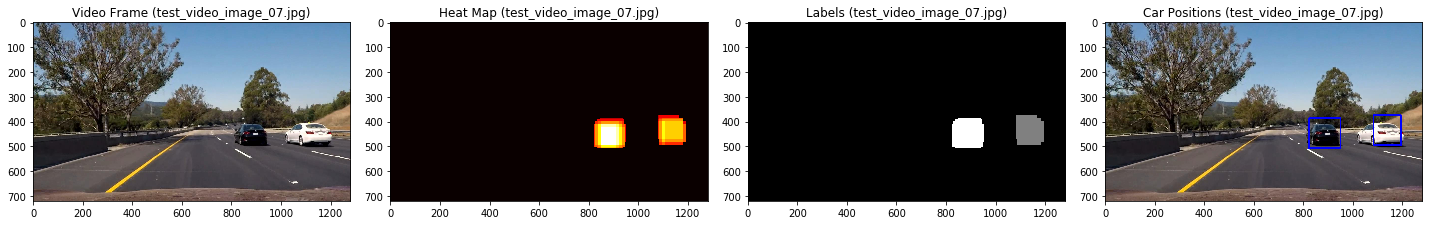

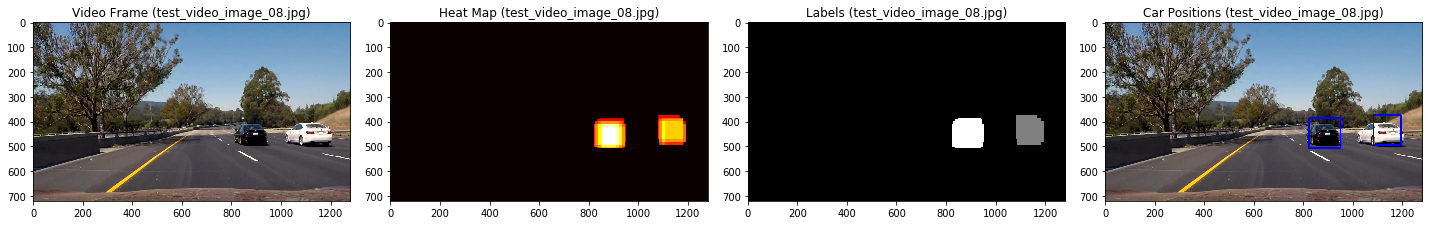

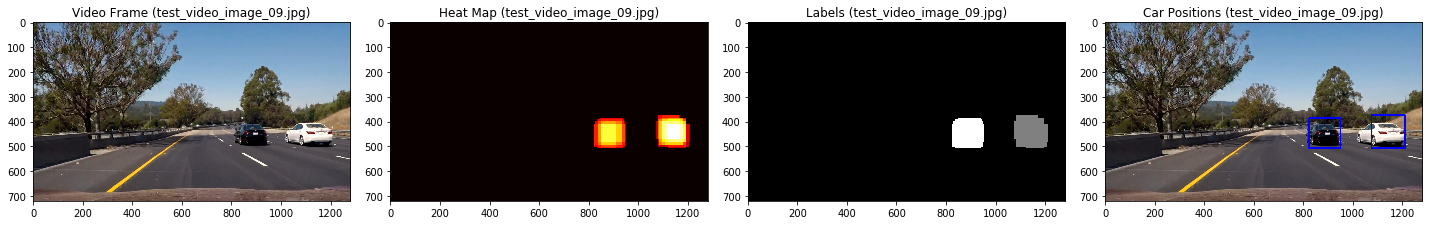

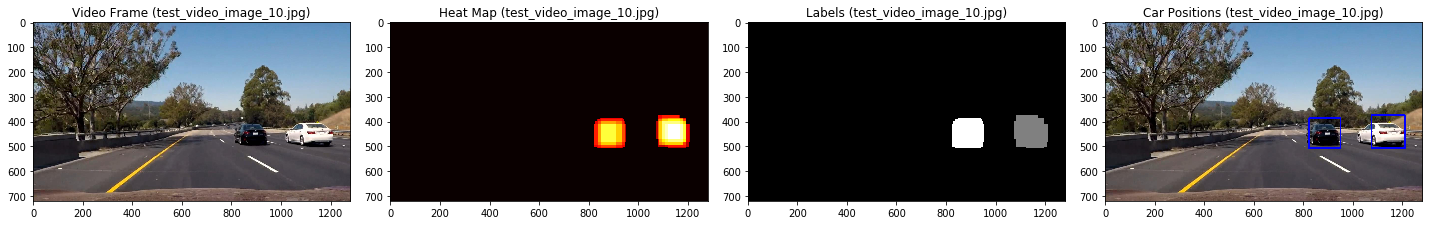

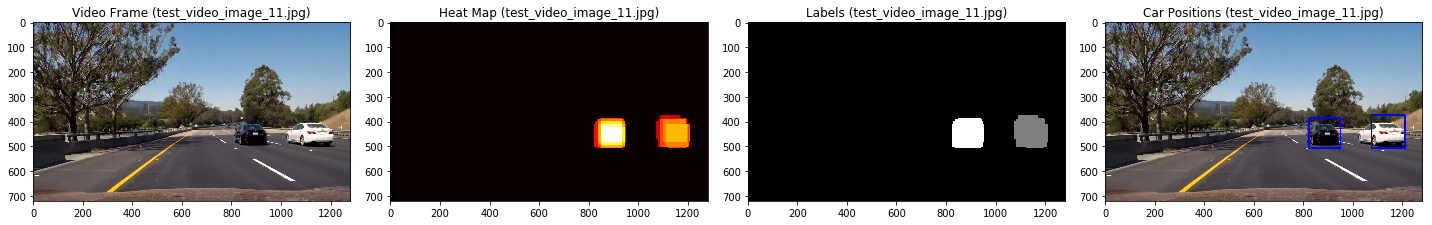

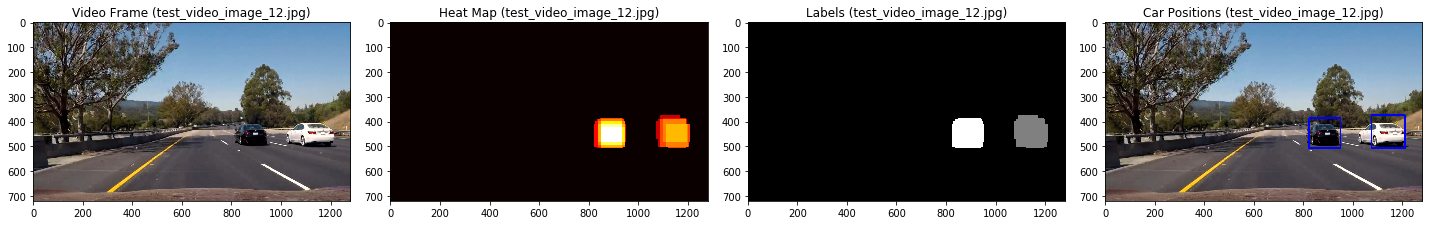

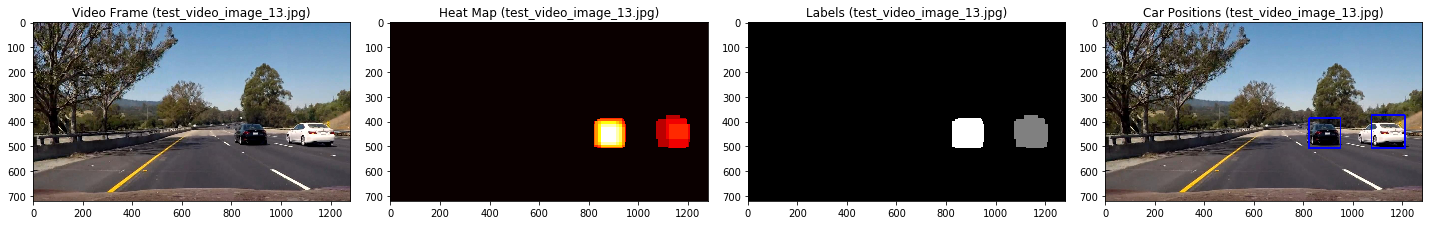

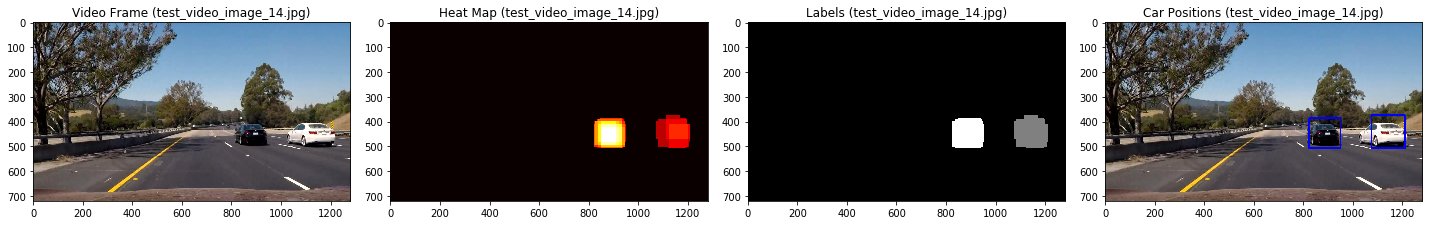

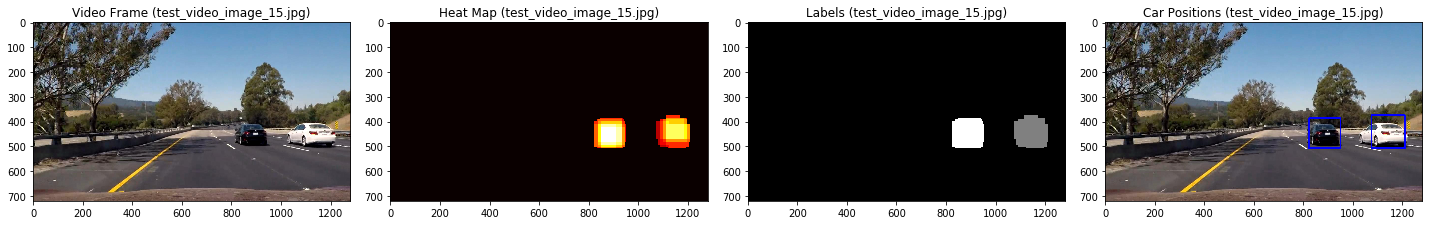

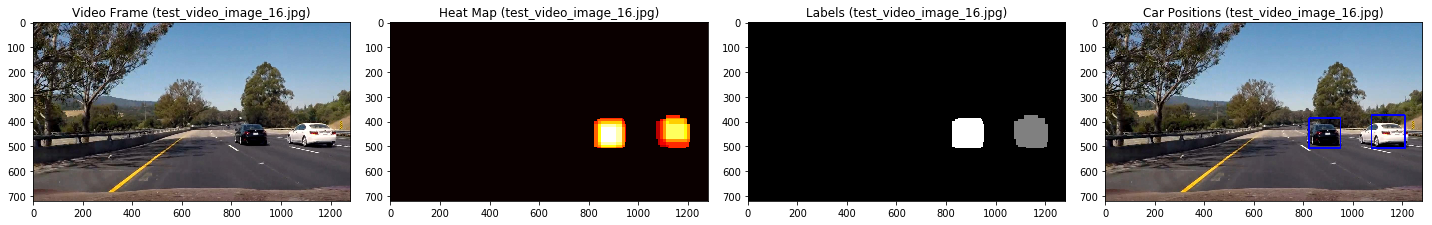

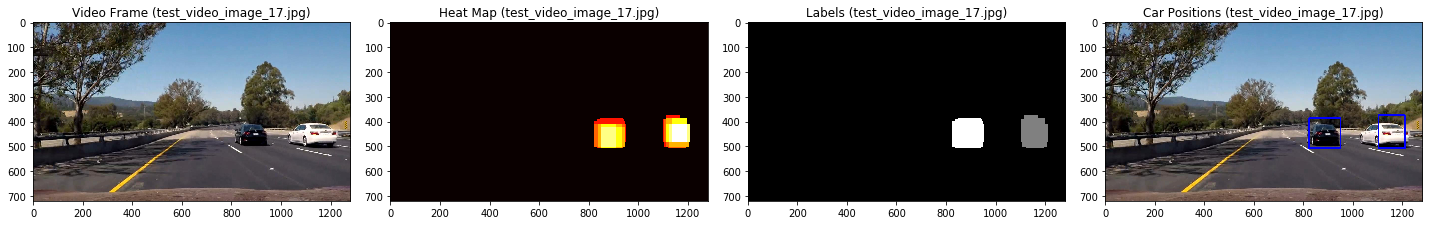

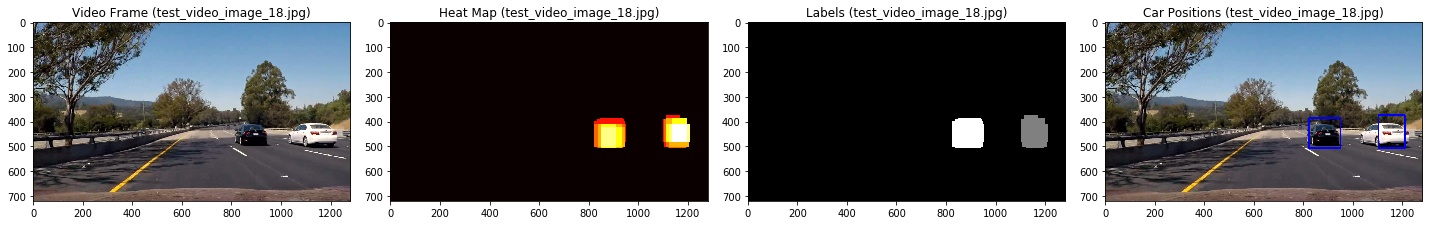

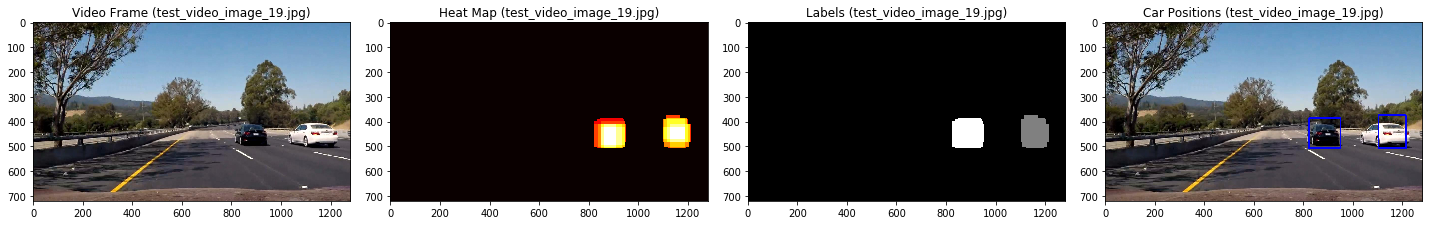

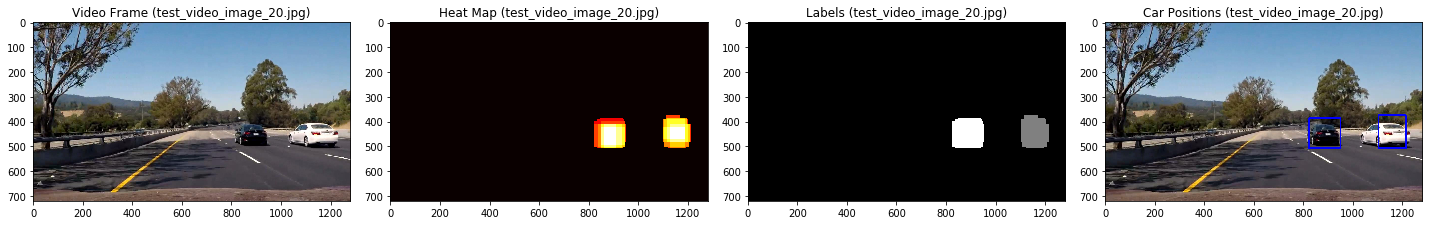

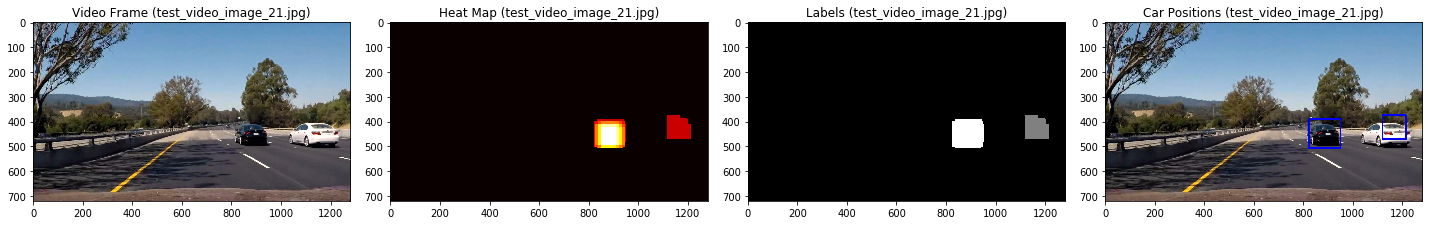

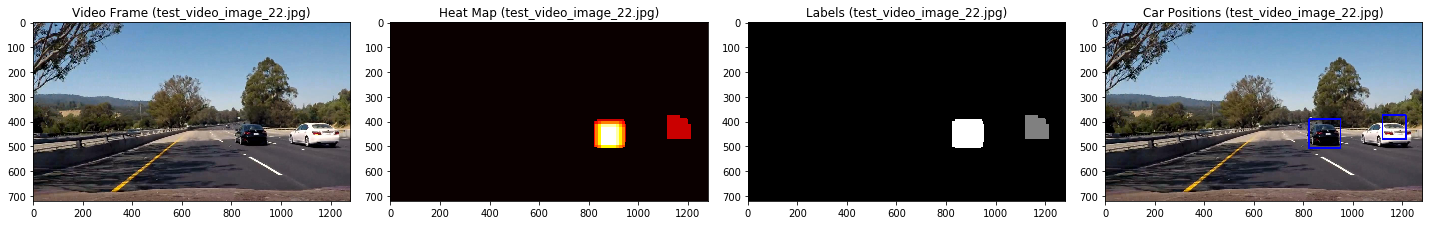

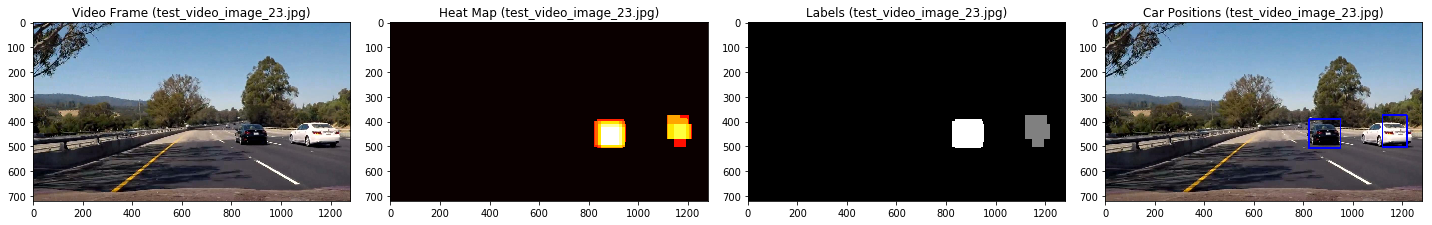

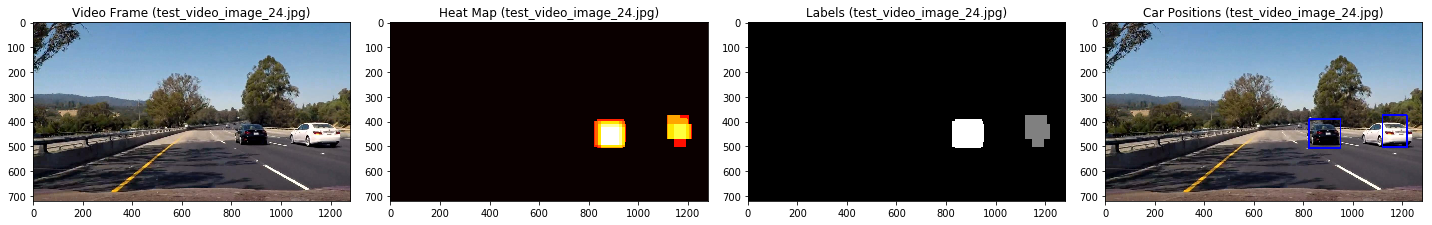

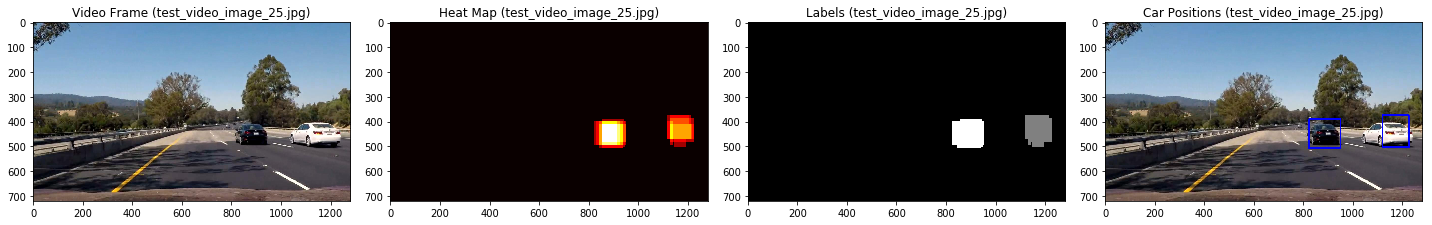

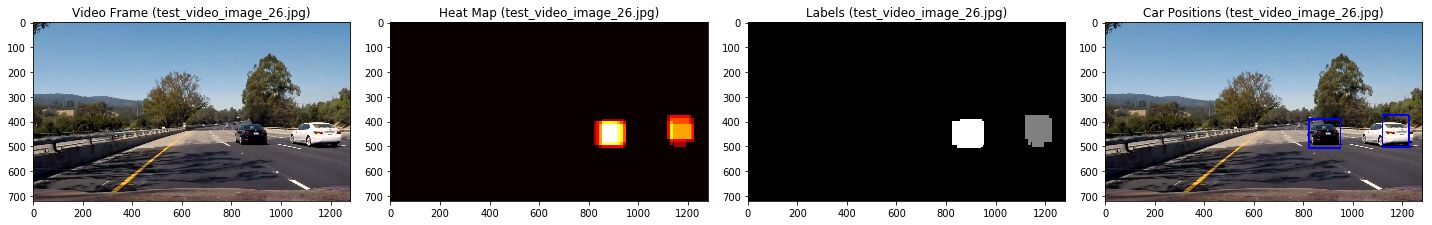

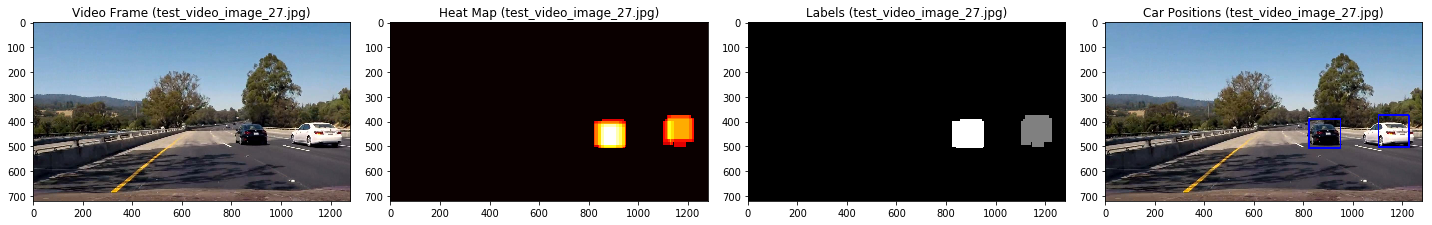

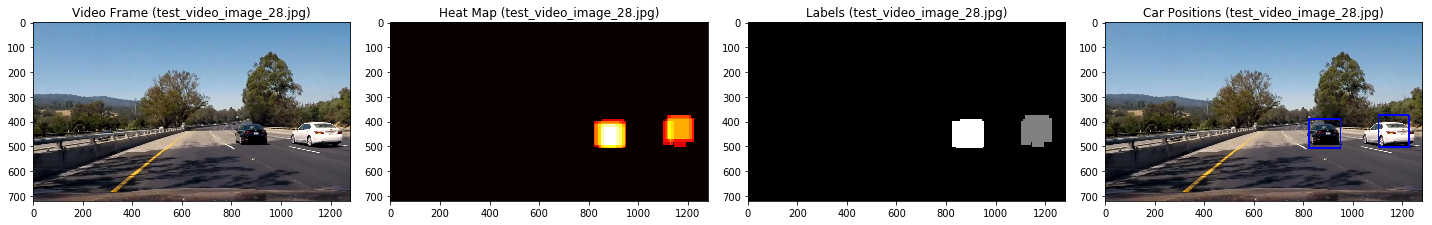

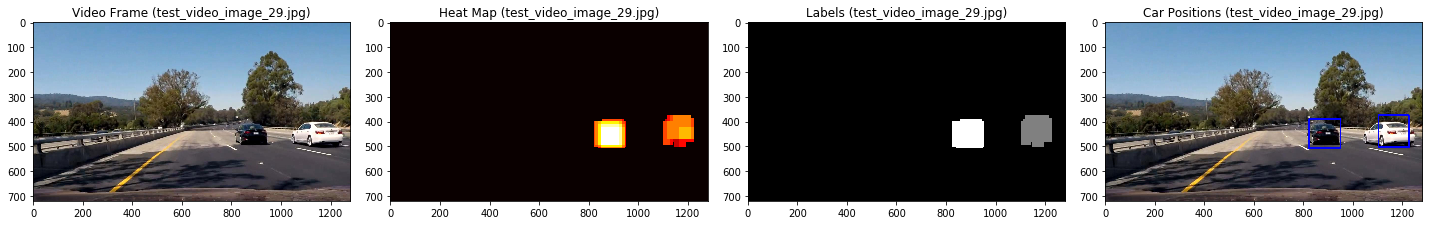

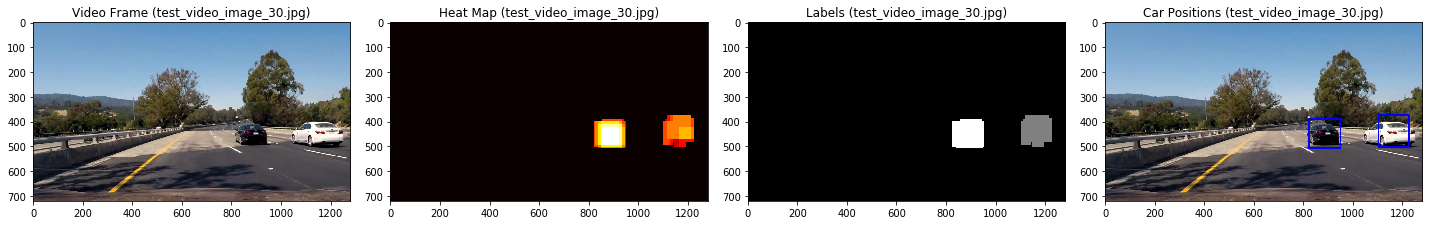

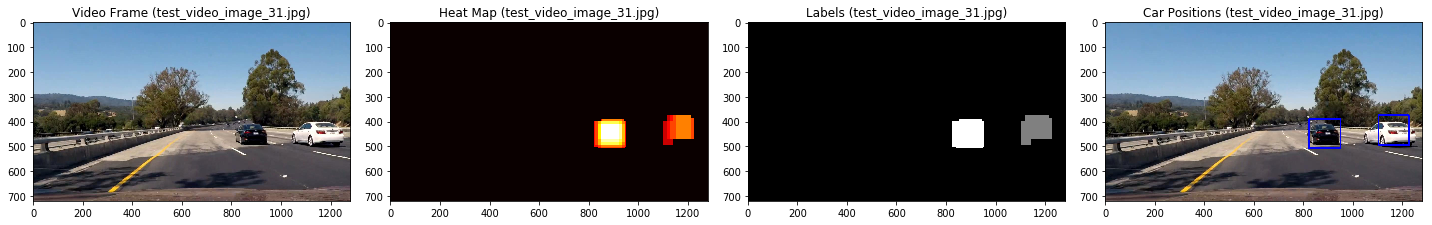

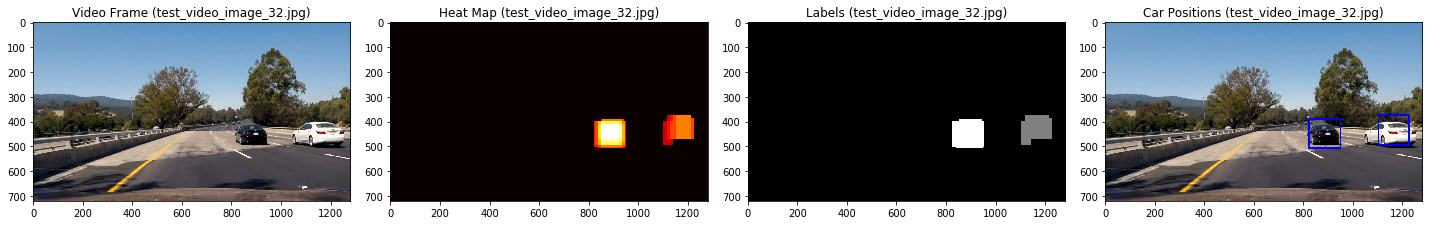

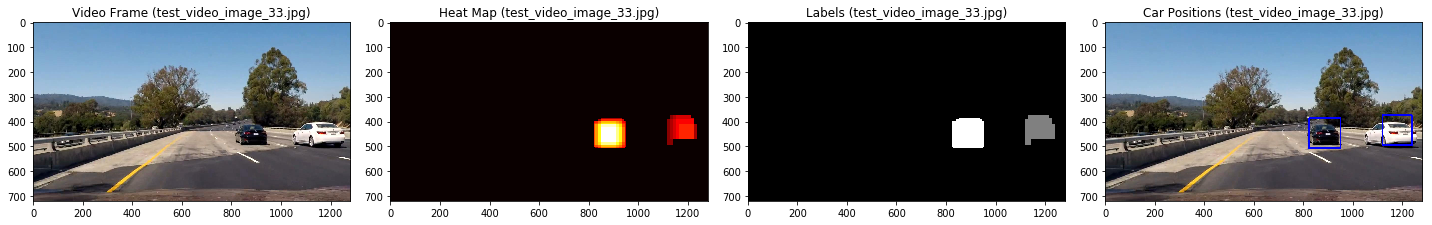

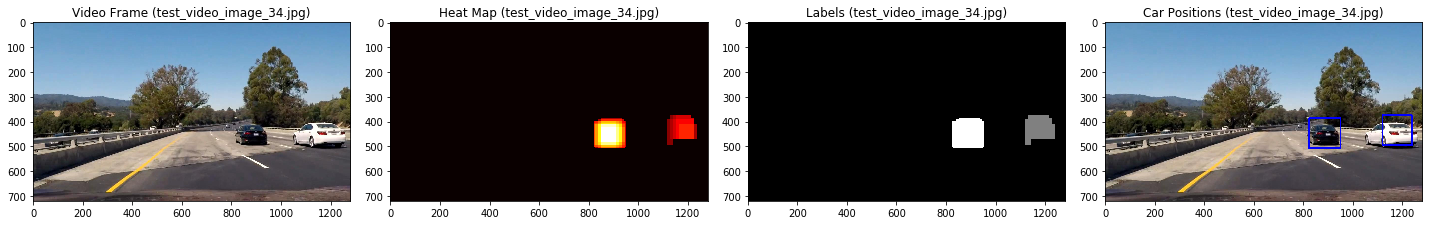

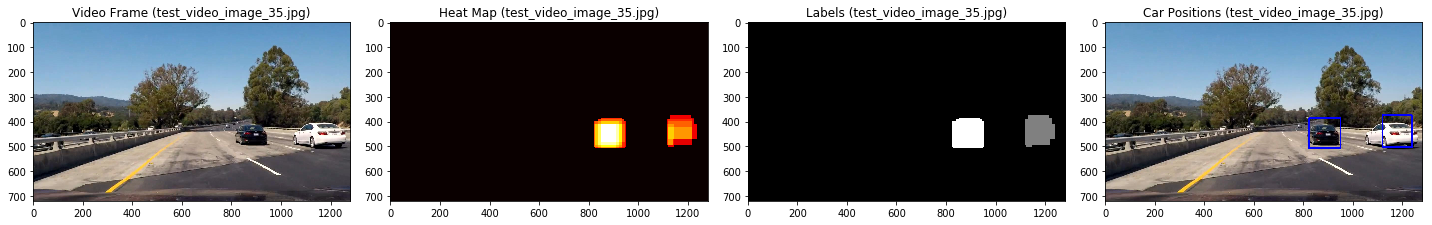

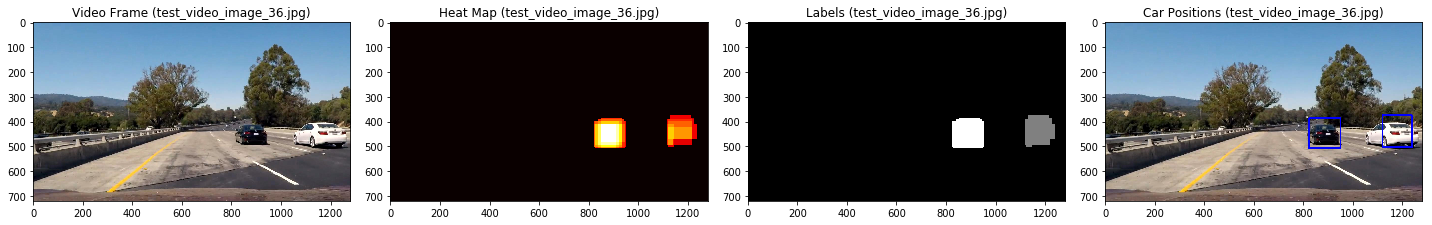

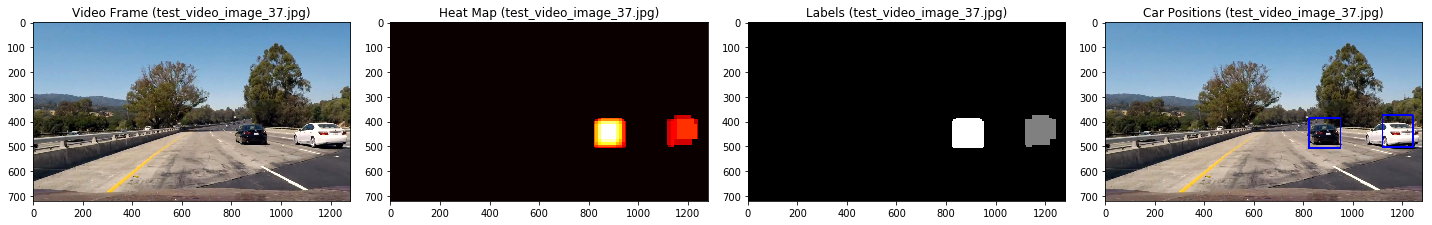

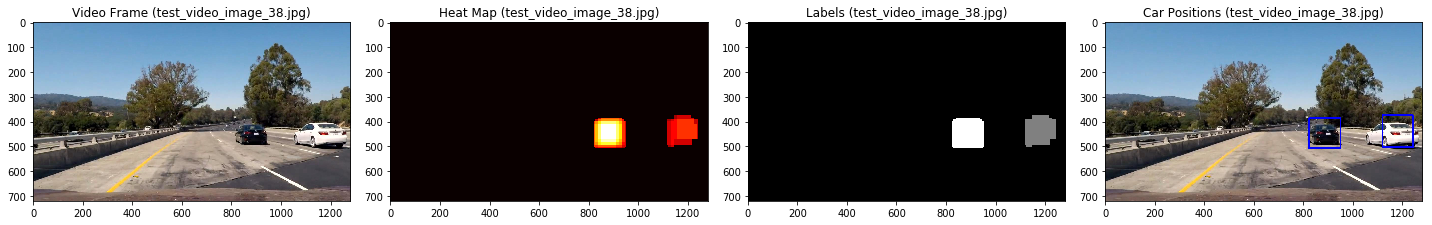

In [847]:
test_images = glob.glob('./test_video_images/*.jpg')

heatmap = []
process_times = []

i = 0
full_search_on_nth_frame_when_not_tracking = 4
full_search_on_nth_frame_when_tracking = 24

for fname in test_images:
    image = cv2.imread(fname)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    tracking = len(heatmap) > 0 and np.count_nonzero(heatmap) > 0
    if tracking:
        n = full_search_on_nth_frame_when_tracking
    else:
        n = full_search_on_nth_frame_when_not_tracking

    limit_search = i % n > 0
    # Skip the analysis of every other frame unless it is a full frame search.
    skip_analysis = i % 2 > 0 and limit_search
    if skip_analysis:
        search_type = 'skip':
    elif: limit_search:
        search_type = 'limited'
    else: 
        search_type = 'light'
        
    t=time.time()
    annotated_image, heatmap, labels = detect_vehicles_in_image(rgb_image, svc, 
                                                                heatmap_threshold=3,
                                                                previous_heatmap=heatmap, 
                                                                verbose=False,
                                                                search_type=search_type,
                                                                return_image_heatmap_and_labels=True)
    t2 = time.time()
    process_time = round(t2-t, 2)
    process_times.append(process_time)
    print(process_time, 'seconds to analyse image')
    
    i += 1
    
    image_name = fname.split('/')[-1]
    
    fig = plt.figure(figsize=(20,4))
    plt.subplot(141)
    plt.imshow(rgb_image)
    plt.title('Video Frame ({})'.format(image_name))
    plt.subplot(142)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map ({})'.format(image_name))    
    plt.subplot(143)
    plt.imshow(labels[0], cmap='gray')
    plt.title('Labels ({})'.format(image_name))    
    plt.subplot(144)
    plt.imshow(annotated_image)
    plt.title('Car Positions ({})'.format(image_name))
    fig.tight_layout()

print('Mean frame processing time: {}'.format(np.mean(process_times)))

In [849]:
project_video_output = './test_video_annotated.avi'
cap = cv2.VideoCapture('./test_video.mp4')

# project_video_output = './project_video_annotated.avi'
# cap = cv2.VideoCapture('./project_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'SVQ3')
out = cv2.VideoWriter(project_video_output, fourcc, 24.0, (1280, 720))

heatmap = []
i = 0
full_search_on_nth_frame_when_not_tracking = 4
full_search_on_nth_frame_when_tracking = 24
save_image_files = False

while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret==True:
        rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        tracking = len(heatmap) > 0 and np.count_nonzero(heatmap) > 0
        if tracking:
            n = full_search_on_nth_frame_when_tracking
        else:
            n = full_search_on_nth_frame_when_not_tracking
        
        limit_search = i % n > 0
        # Skip the analysis of every other frame unless it is a full frame search.
        skip_analysis = i % 2 > 0 and limit_search
        if skip_analysis:
            search_type = 'skip':
        elif: limit_search:
            search_type = 'limited'
        else: 
            search_type = 'light'
        annotated_image, heatmap = detect_vehicles_in_image(rgb_image, svc, 
                                                            heatmap_threshold=3,
                                                            previous_heatmap=heatmap,
                                                            search_type=search_type,
                                                            return_image_and_heatmap=True)
        i += 1
        if save_image_files:
            image_filename = './test_video_images/test_video_image_{}.jpg'.format(i)
            toimage(rgb_image, cmin=0.0, cmax=...).save(image_filename)
        # write the annotated frame
        out.write(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR) )
    else:
        break

# Release everything if the job is finished
cap.release()
out.release()